In [52]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
# load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


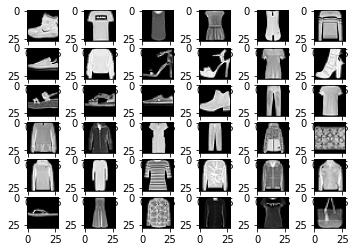

In [53]:
import cv2

# plot first few images
for i in range(36):
        plt.subplot(6, 6, 1 + i)
        plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
# show the figure
plt.show()

In [54]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [55]:
# Normalize the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [56]:
import tensorflow as tf

num_classes = 10
learning_rate = 0.01

# One hot encode the labels (neural nets only like numbers)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [57]:
item_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
              3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
              7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [58]:
# WandB – Install the W&B library
#!pip install wandb -q
#!pip install opencv-python
import wandb
from wandb.keras import WandbCallback

In [67]:
# Initilize a new wandb run
wandb.init(entity="yhenig", project="project")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = learning_rate
config.epochs = 133
config.img_width=28
config.img_height=28
config.num_classes = num_classes
config.batch_size = 128
config.validation_size = 5000
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'nadam'
config.seed = 42

epoch,279
loss,0.13391
accuracy,0.94939
val_loss,0.3276
val_accuracy,0.8984
_runtime,2574
_timestamp,1627392051
_step,279
best_val_loss,0.27891
best_epoch,125


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▄▂▅▅▅▅▆▅█▆▆▅▅▆▆▆▅▅▄▁▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄
accuracy,▄▇▃▃▃▃▂▃▁▃▂▃▃▂▃▃▃▃▅█▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▅
val_loss,▂▅▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂█▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_accuracy,▃▅▆█▃▅▄▄▅▅▄▄▂▆▄▂▆▆▆▂▅▅▅▆▄▃▅▄▄▁▄▃▄▇▇█▄▄▄▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [60]:
# define cnn model
def define_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    # define the optimizer
    optimizer = tf.keras.optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    # compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [61]:
def augmentation(X_data):
    # Data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_data)

In [68]:
%%wandb
# define model
model = define_model()

# data augmentation
augmentation(X_train)

# fit model
history = model.fit(X_train, y_train,
                    epochs=config.epochs, batch_size=config.batch_size,
                    validation_data=(X_test, y_test),
                    verbose=0,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                              WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=item_names)])
# evaluate model
_, acc = model.evaluate(X_test, y_test, verbose=0)

first run with 9 epochs

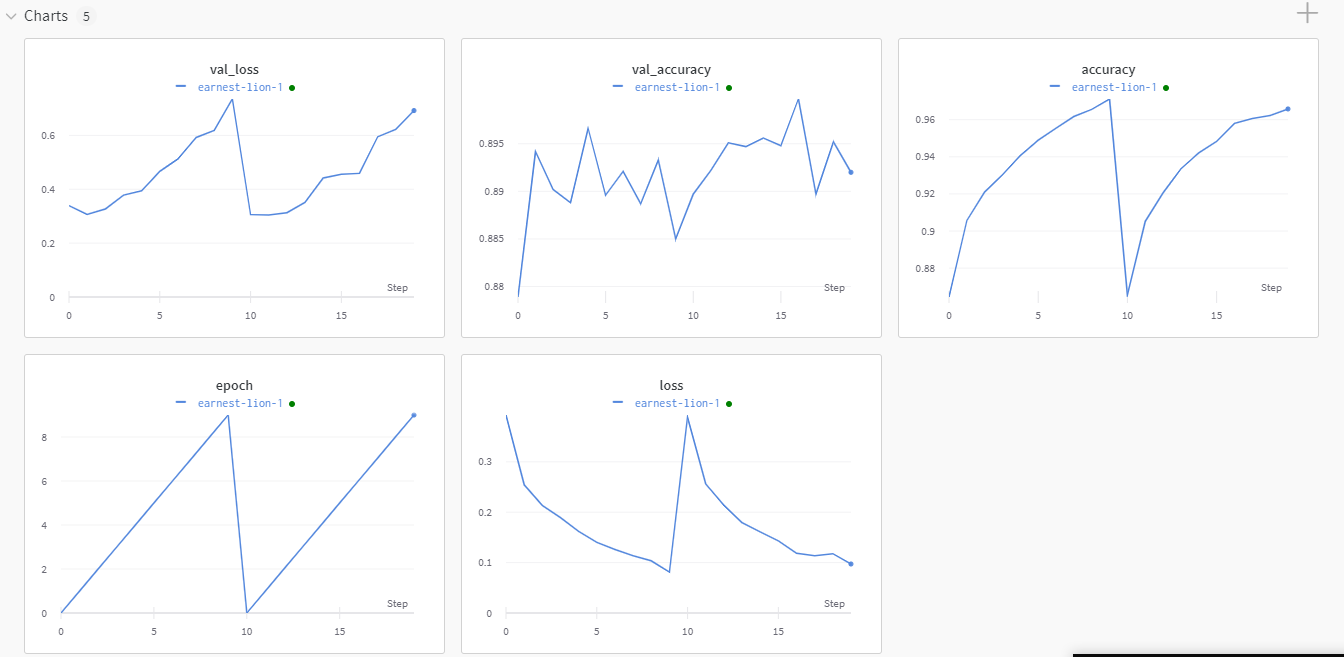

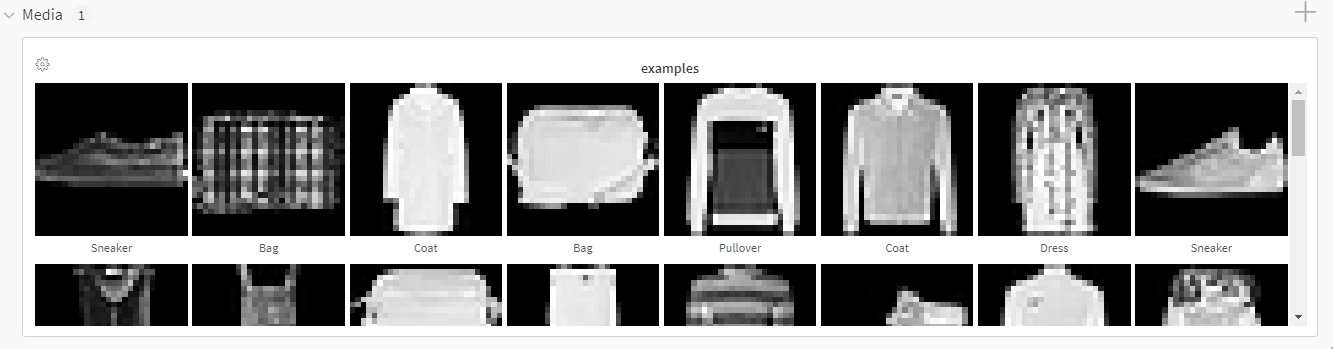

In [69]:
print(f'Acc: {(acc * 100.0):.3f}%')

Acc: 90.540%


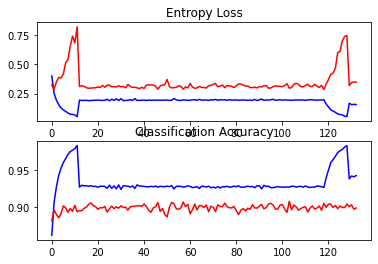

In [70]:
# plot loss
pyplot.subplot(211)
pyplot.title('Entropy Loss')
pyplot.plot(history.history['loss'], color='b', label='train')
pyplot.plot(history.history['val_loss'], color='r', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='b', label='train')
pyplot.plot(history.history['val_accuracy'], color='r', label='test')

plt.show()

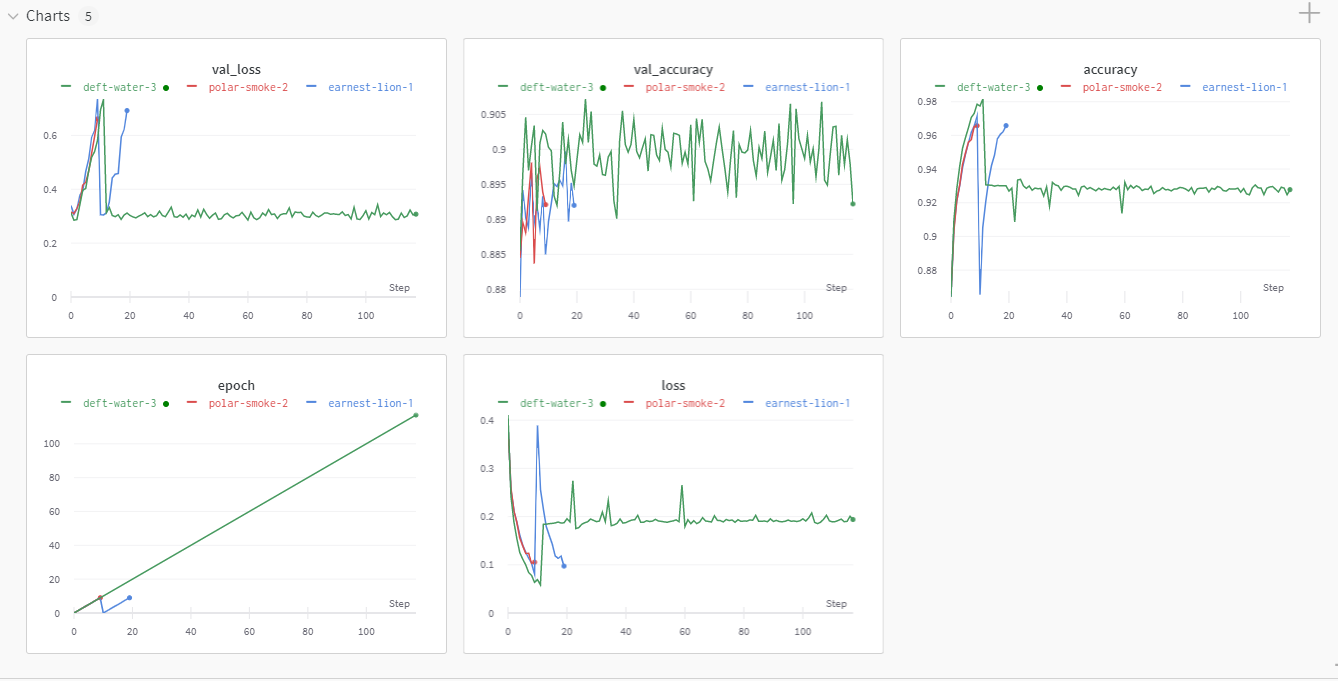

In [71]:
model.save('model1.h5')